In [1]:
import pandas as pd
import datetime

interest_rates = pd.read_csv('Interest_rates.csv')
interest_rates['date'] = pd.to_datetime(interest_rates['date'], dayfirst=True)
interest_rates = interest_rates[interest_rates['date'] >= datetime.datetime(2021, 1, 1)]

In [2]:
dates = interest_rates.reset_index()['date'].tolist()
rates = interest_rates['interest_rate'].tolist()

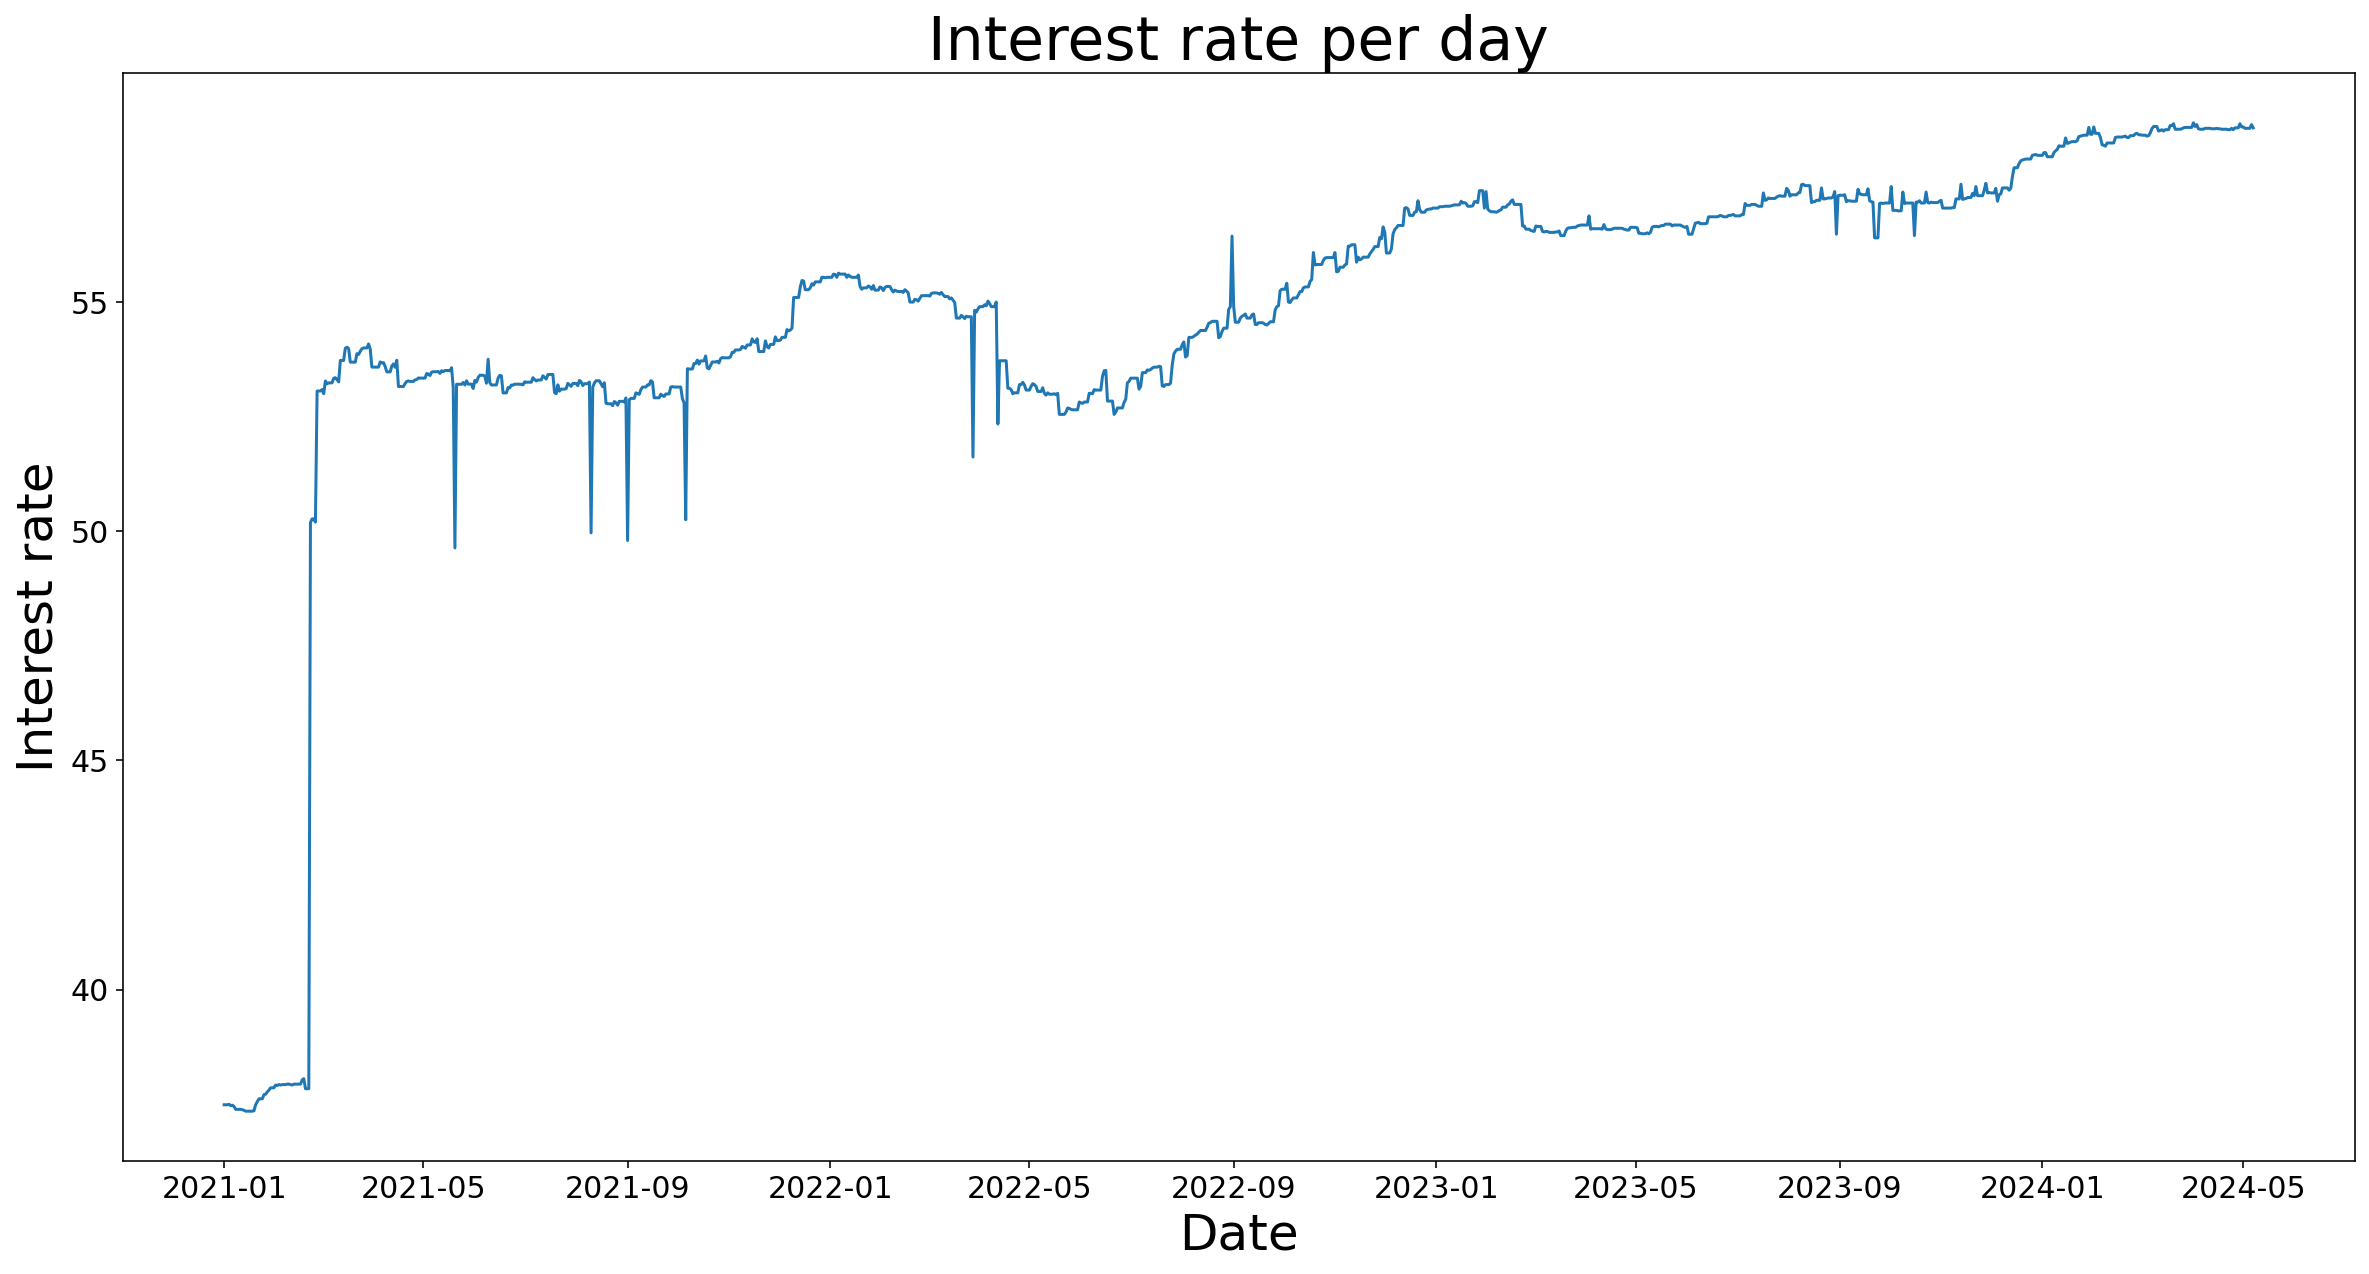

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10

plt.plot(dates, rates)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('Interest rate per day', fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

period = 128
scaler = MinMaxScaler(feature_range=(0, 1))
test = rates[-period:]
test_dates = dates[-period:]
train = scaler.fit_transform(np.array(rates[:-period]).reshape(-1, 1))

### Need to split train data into sequences. ###

In [5]:
def create_sequences(dataset, train_batch):
    X_train, Y_train = [], []
    for i in range(len(dataset)-train_batch):
        X_train.append(dataset[i:(i+train_batch), 0])
        Y_train.append(dataset[i+train_batch, 0])
    return np.array(X_train), np.array(Y_train)

### Let's take best train_batch parameter from xgboost. ###

In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

tf.random.set_seed(42)
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(None, 1), activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False, input_shape=(None, 1), activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2024-05-18 04:55:45.002719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.metrics import mean_squared_error
best_train_batch = 35
X_train, y_train = create_sequences(train, best_train_batch)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
X_train_ = train[-best_train_batch:].reshape(1, best_train_batch, 1)
test_pred = []
for i in range(period):
    next_pred = model.predict(X_train_, verbose=0)
    X_train_ = X_train_.reshape(X_train_.shape[1])[1:]
    X_train_ = np.append(X_train_, next_pred)
    X_train_ = X_train_.reshape(1, best_train_batch, 1)
    test_pred.append(next_pred[0][0])

test_pred = scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(period)
test_RMSE = mean_squared_error(test, test_pred, squared=False)
test_rel_error = ((abs(test - test_pred)) / test) * 100
print("Test RMSE = %.3f" % test_RMSE, sep="")
print("Test relative error = %.3f" % test_rel_error.mean(), '%', sep="")
print("Last test relative error = %.3f" % test_rel_error[-1], '%', sep="")

Test RMSE = 1.613
Test relative error = 2.584%
Last test relative error = 3.704%


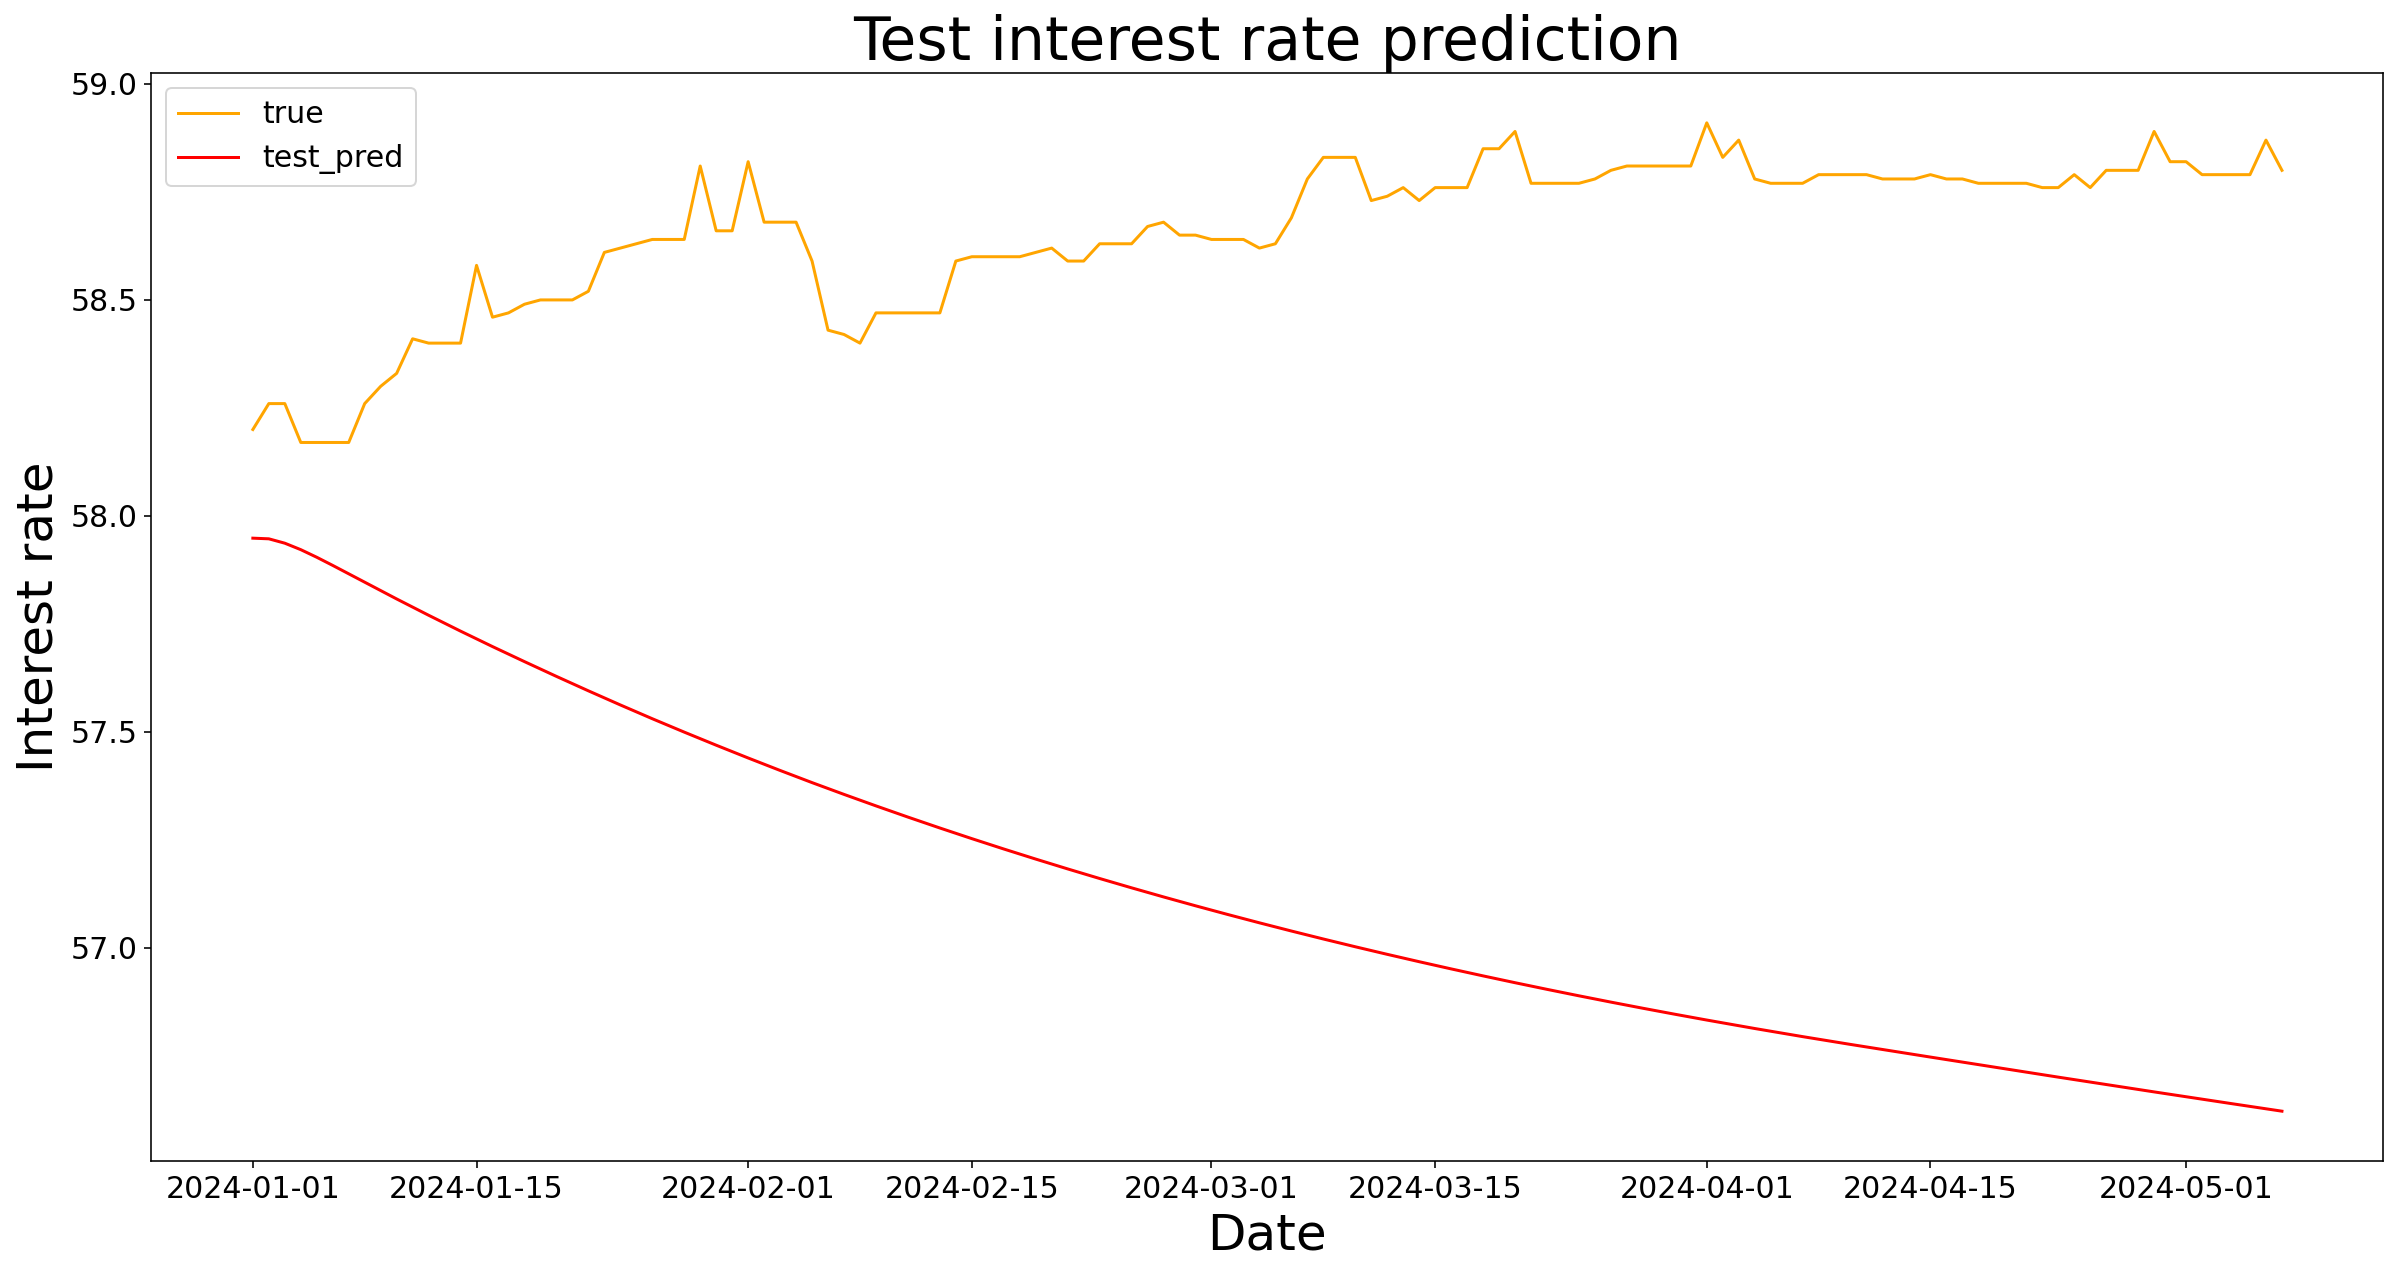

In [8]:
plt.title("Test interest rate prediction", fontsize = 30)
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, test_pred, color = 'red', label = 'test_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Interest rate", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()